# BNL Development Notebook

This notebook is for developing and testing the BNL package.


In [34]:
%load_ext autoreload
%autoreload 2

import bnl

# R2_BUCKET_PUBLIC_URL = "https://pub-05e404c031184ec4bbf69b0c2321b98e.r2.dev"

# slm_ds = bnl.data.Dataset(manifest_path=f"{R2_BUCKET_PUBLIC_URL}/manifest_cloud_boolean.csv")
slm_ds = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
track = slm_ds[8]
est = track.load_annotation("adobe-mu1gamma1")
ref = track.load_annotation("reference")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
for strategy in ["count", "depth", "prob"]:
    bc = est.to_contour(strategy=strategy)
    fig = bc.plot_plotly()
    fig.update_layout(title=f"{fig.layout.title.text}: salience by {strategy}")
    fig.show()

In [47]:
import importlib
importlib.reload(bnl.ops)
bnl.ops.CleanStrategy._registry

{'absorb': bnl.ops._CleanByAbsorb, 'kde': bnl.ops._CleanByKDE}

count
2 boundaries left
depth
2 boundaries left
prob
2 boundaries left


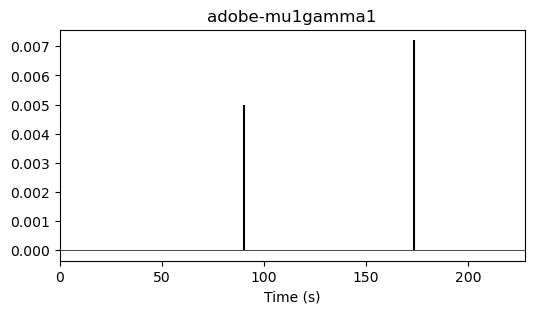

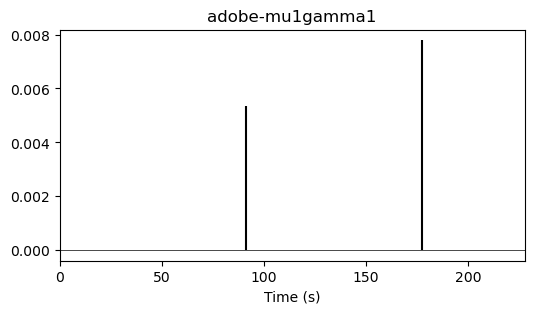

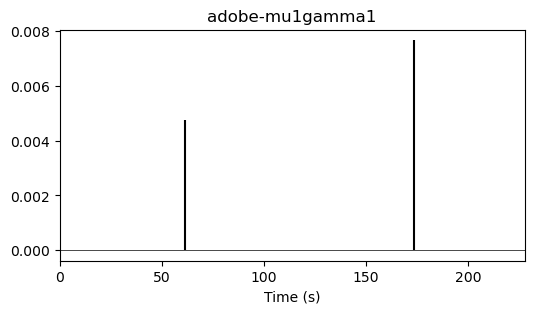

In [ ]:
for sal_strat in ['count', 'depth', 'prob']:
    print(sal_strat)
    bc = est.to_contour(sal_strat).clean(strategy="kde", time_bw=15)
    bc.plot(figsize=(6,3))
    print(len(bc), 'boundaries left')

<Axes: title={'center': 'adobe-mu1gamma1'}, xlabel='Time (s)'>

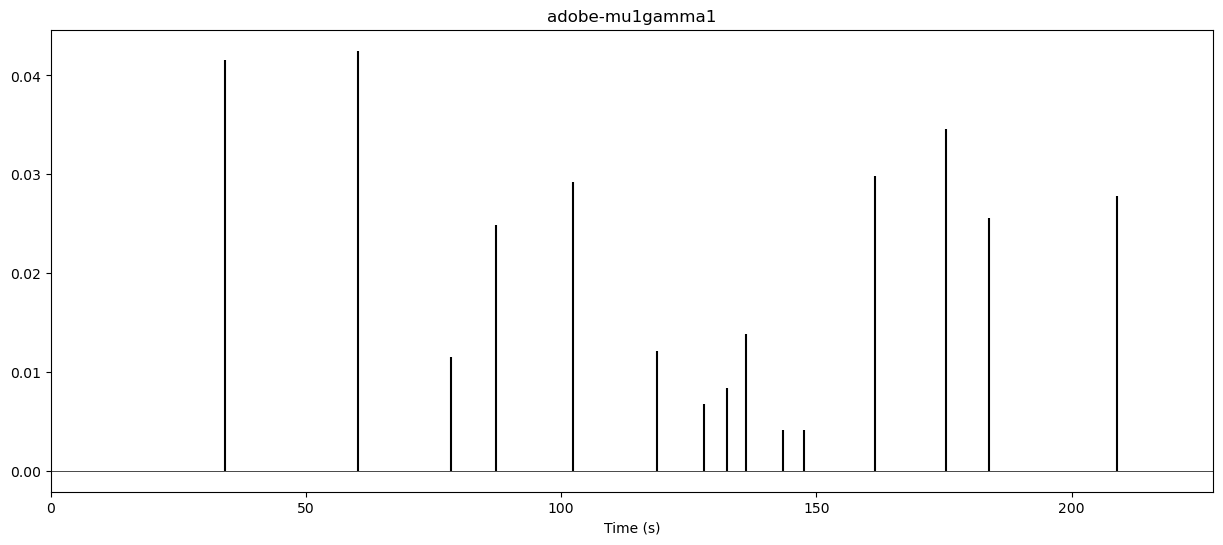

In [51]:
est.to_contour('count').clean(strategy="kde", time_bw=1.0).plot()

<Axes: title={'center': 'adobe-mu1gamma1'}, xlabel='Time (s)'>

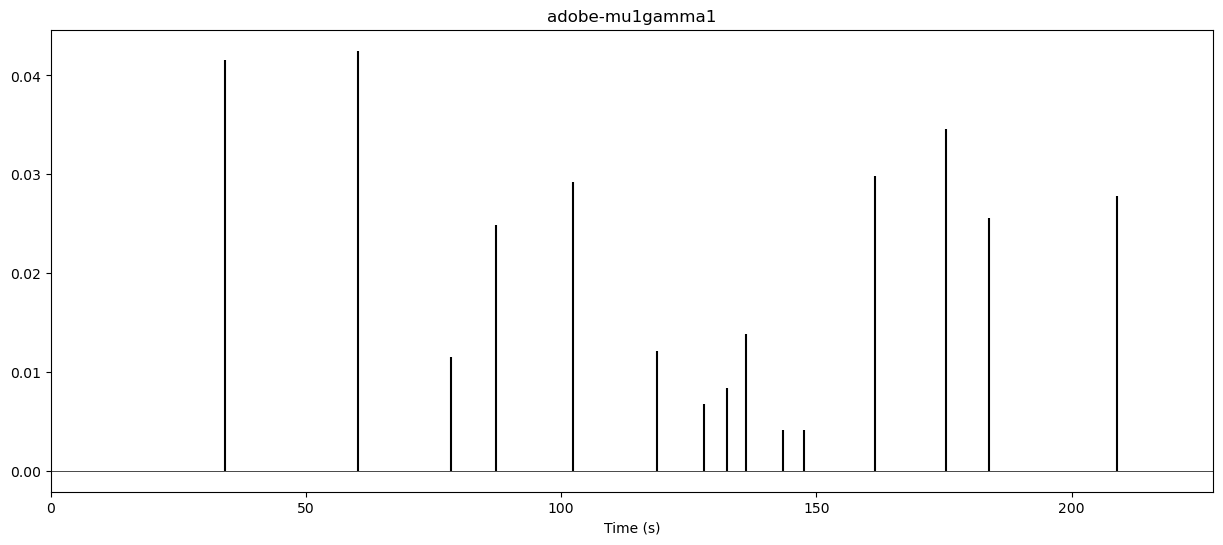

In [ ]:
est.to_contour('count').clean(strategy="kde", time_bw=1.0).plot()

In [29]:
bnl.ops.SalienceStrategy._registry['prob']

In [ ]:

# Try loading an Adobe annotation that exists
est = track.load_annotation("adobe-mu1gamma1")
est.plot_plotly(figsize=(600, 400))

In [ ]:
ref = track.load_annotation("reference")
ref.plot_plotly()

In [ ]:
ref.plot_plotly(figsize=None)

In [ ]:
for strategy in ["depth", "count", "prob"]:
    # Using the new fluent API
    contour = est.to_contour(strategy=strategy)
    contour.plot(figsize=(6,3))

    # Convert to hierarchy and then to multisegment for visualization
    hierarchy = contour.to_hierarchy()
    mono_ms = hierarchy.to_multisegment()
    mono_ms.plot(figsize=(6, 3))

In [ ]:
# Demonstrating the new boundary cleaning functionality
print("Original boundary cleaning strategies:")

# Get a boundary contour
contour = est.to_contour(strategy="depth")
print(f"Original contour has {len(contour.boundaries)} boundaries")

# Try different cleaning strategies
for strategy in ["absorb", "kde"]:
    print(f"\nCleaning with {strategy} strategy:")

    if strategy == "absorb":
        # For absorb, we can specify a window parameter
        cleaned = contour.clean(strategy=strategy, window=1.0)
    else:  # kde
        # For kde, we can specify bandwidth and frame_size
        cleaned = contour.clean(strategy=strategy, bandwidth=1.0, frame_size=0.1)

    print(f"  Cleaned contour has {len(cleaned.boundaries)} boundaries")
    cleaned.plot(figsize=(6, 2))


In [ ]:
# Demonstrating the new boundary cleaning functionality
print("Original boundary cleaning strategies:")

# Get a boundary contour
contour = est.to_contour(strategy="depth")
print(f"Original contour has {len(contour.boundaries)} boundaries")

# Try different cleaning strategies
for strategy in ["absorb", "kde"]:
    print(f"\nCleaning with {strategy} strategy:")
    
    if strategy == "absorb":
        # For absorb, we can specify a window parameter
        cleaned = contour.clean(strategy=strategy, window=1.0)
    else:  # kde
        # For kde, we can specify bandwidth and frame_size
        cleaned = contour.clean(strategy=strategy, bandwidth=1.0, frame_size=0.1)
    
    print(f"  Cleaned contour has {len(cleaned.boundaries)} boundaries")
    cleaned.plot(figsize=(6, 2))


In [ ]:
# Demonstrating the new boundary cleaning functionality
print("Original boundary cleaning strategies:")

# Get a boundary contour
contour = est.to_contour(strategy="depth")
print(f"Original contour has {len(contour.boundaries)} boundaries")

# Try different cleaning strategies
for strategy in ["absorb", "kde"]:
    print(f"\nCleaning with {strategy} strategy:")
    
    if strategy == "absorb":
        # For absorb, we can specify a window parameter
        cleaned = contour.clean(strategy=strategy, window=1.0)
    else:  # kde
        # For kde, we can specify bandwidth and frame_size
        cleaned = contour.clean(strategy=strategy, bandwidth=1.0, frame_size=0.1)
    
    print(f"  Cleaned contour has {len(cleaned.boundaries)} boundaries")
    cleaned.plot(figsize=(6, 2))


In [ ]:
# Demonstrating the beautiful fluent API chaining
print("Fluent API chaining - the full pipeline in one expression:")

# The complete pipeline: estimate -> contour -> clean -> hierarchy -> multisegment
final_result = (
    est.to_contour(strategy="depth")
       .clean(strategy="absorb", window=0.5)
       .to_hierarchy()
       .to_multisegment()
)

print(f"Final result has {len(final_result)} layers")
final_result.plot(figsize=(8, 4))
